In [33]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [55]:
import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

import sklearn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

from dtreeviz import trees 

import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import pandas as pd
import numpy as np
from dtreeviz.shadow import ShadowDecTree
from dtreeviz.shadow2 import ShadowDecTree2
from dtreeviz.models.decision_trees import XGBDTree
from dtreeviz import treeviz
from dtreeviz import exceptions

In [35]:
pd.options.display.max_rows = 999

# Train

In [36]:
random_state = 1234
dataset = pd.read_csv("../data/titanic/titanic.csv")
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

In [37]:
dtrain = xgb.DMatrix(dataset[features], dataset[target])

In [38]:
params = {"max_depth":2, "eta":0.05, "objective":"binary:logistic", "subsample":1}

In [39]:
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=8)

In [40]:
xgb_model.trees_to_dataframe().query("Tree == 0")

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,Sex_label,1.0,0-1,0-2,0-1,246.604279,222.75
1,0,1,0-1,Pclass,3.0,0-3,0-4,0-3,60.127525,78.50
2,0,2,0-2,Cabin_label,4.0,0-5,0-6,0-5,29.516968,144.25
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,0.087356,42.50
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,-0.000000,36.00
5,0,5,0-5,Leaf,NaN,NaN,NaN,NaN,-0.072327,118.25
6,0,6,0-6,Leaf,NaN,NaN,NaN,NaN,-0.012963,26.00


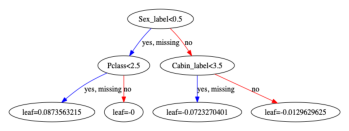

In [41]:
# rcParams['figure.figsize'] = 50,30
plot_tree(xgb_model)

# save the model

In [42]:
import joblib
# joblib.dump(xgb_model, "xgb_model")

# Setup

In [43]:
dataset[features + [target]].iloc[:20].to_csv("dataset.csv", index=False)

In [44]:
d = dataset[features].iloc[:20]
d_matrix = xgb.DMatrix(d)

# Investigating prediction path

In [45]:
xgb_model.predict(d_matrix, pred_leaf=True)

array([[5, 5, 5, 6, 5, 5, 6, 5],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [5, 5, 5, 6, 5, 5, 6, 5],
       [5, 5, 5, 6, 5, 5, 6, 5],
       [6, 6, 6, 6, 6, 6, 6, 6],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [5, 5, 5, 6, 5, 5, 6, 5],
       [5, 5, 5, 6, 5, 5, 6, 5],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 6, 5, 5, 6, 5],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4]], dtype=int32)

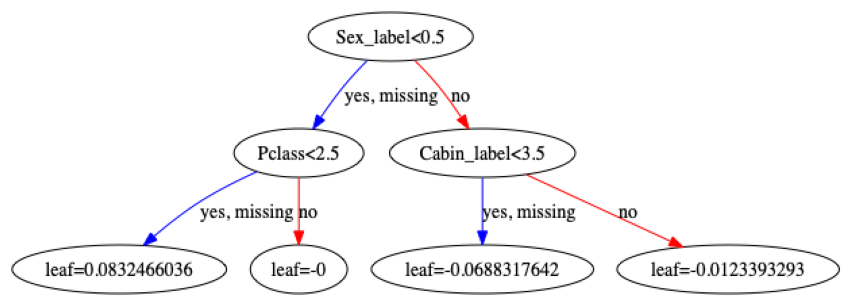

In [46]:
rcParams['figure.figsize'] = 15,10
plot_tree(xgb_model, num_trees=1)

In [47]:
dataset[features].iloc[:20]

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
0,3,22.000000,7.2500,1,-1,2
1,1,38.000000,71.2833,0,81,0
2,3,26.000000,7.9250,0,-1,2
3,1,35.000000,53.1000,0,55,2
4,3,35.000000,8.0500,1,-1,2
5,3,29.699118,8.4583,1,-1,1
6,1,54.000000,51.8625,1,129,2
7,3,2.000000,21.0750,1,-1,2
8,3,27.000000,11.1333,0,-1,2
9,2,14.000000,30.0708,0,-1,0


In [48]:
xgb_tree = XGBDTree(xgb_model, 1)


In [49]:
xgb_tree._get_leaf_prediction_path(3)

[3, 1, 0]

# Parameters meaning
- cover https://stackoverflow.com/questions/33520460/how-is-xgboost-cover-calculated
- https://rdrr.io/cran/xgboost/man/xgb.model.dt.tree.html
- https://eli5.readthedocs.io/en/latest/tutorials/index.html

## left, right children

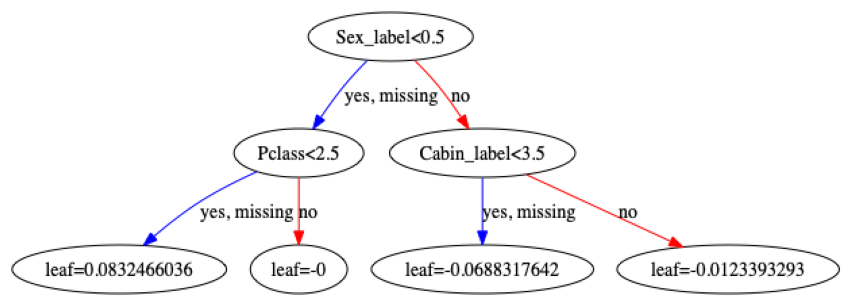

In [50]:
rcParams['figure.figsize'] = 15,10
plot_tree(xgb_model, num_trees=1)

[ 1  3  5 -1 -1 -1 -1]
[ 2  4  6 -1 -1 -1 -1]


In [97]:
[node.id for node in shadow2.internal]

[1, 2, 0]

In [98]:
[node.id for node in shadow2.leaves]

[3, 4, 5, 6]

## Node split/threshold

In [99]:
??plot_tree

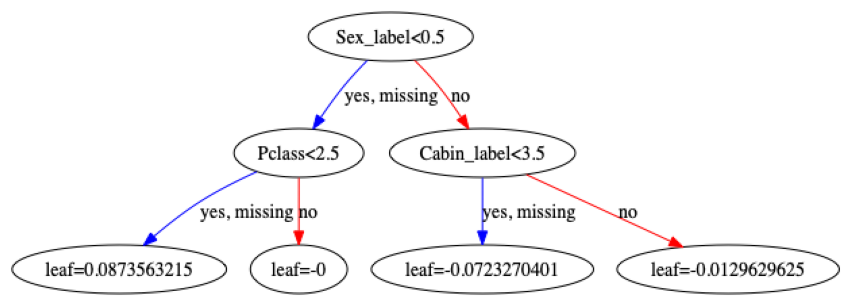

In [100]:
rcParams['figure.figsize'] = 15,10
plot_tree(xgb_model, num_trees=0)

In [74]:
??xgb_model.get_dump

In [69]:
xgb_model.get_dump(dump_format="dot")[1]

'digraph {\n    graph [ rankdir=TB ]\n\n    0 [ label="Sex_label<0.5" ]\n    0 -> 1 [label="yes, missing" color="#0000FF"]\n    0 -> 2 [label="no" color="#FF0000"]\n\n    1 [ label="Pclass<2.5" ]\n    1 -> 3 [label="yes, missing" color="#0000FF"]\n    1 -> 4 [label="no" color="#FF0000"]\n\n    3 [ label="leaf=0.0832466036" ]\n\n    4 [ label="leaf=-0" ]\n\n    2 [ label="Cabin_label<3.5" ]\n    2 -> 5 [label="yes, missing" color="#0000FF"]\n    2 -> 6 [label="no" color="#FF0000"]\n\n    5 [ label="leaf=-0.0688317642" ]\n\n    6 [ label="leaf=-0.0123393293" ]\n}'

In [73]:
??xgb_model.trees_to_dataframe

In [77]:
xgb_model.trees_to_dataframe().query(f"Tree ==1")

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
7,1,0,1-0,Sex_label,1.0,1-1,1-2,1-1,223.169312,222.513412
8,1,1,1-1,Pclass,3.0,1-3,1-4,1-3,54.557060,78.419022
9,1,2,1-2,Cabin_label,4.0,1-5,1-6,1-5,26.723022,144.094391
10,1,3,1-3,Leaf,NaN,NaN,NaN,NaN,0.083247,42.419022
11,1,4,1-4,Leaf,NaN,NaN,NaN,NaN,-0.000000,36.000000
12,1,5,1-5,Leaf,NaN,NaN,NaN,NaN,-0.068832,118.095490
13,1,6,1-6,Leaf,NaN,NaN,NaN,NaN,-0.012339,25.998909


In [20]:
xgb_tree = XGBDTree(xgb_model, tree_index=1)

In [21]:
xgb_tree._get_column_value("Split")

array([ 1.,  3.,  4., nan, nan, nan, nan])

In [22]:
[node.split() for node in sh2.leaves], [node.split() for node in sh2.internal]

([-2, -2, -2, -2], [3.0, 4.0, 1.0])

In [23]:
xgb_tree.get_node_split(0)

1.0

## Node feature

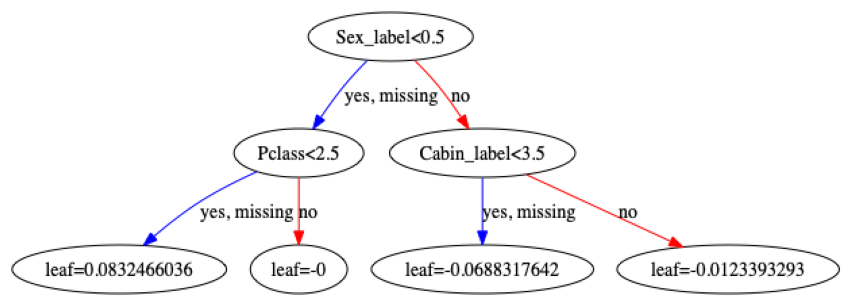

In [34]:
rcParams['figure.figsize'] = 15,10
plot_tree(xgb_model, num_trees=1)

In [32]:
xgb_model.feature_names

['Pclass', 'Age', 'Fare', 'Sex_label', 'Cabin_label', 'Embarked_label']

In [35]:
[(node.id, node.feature()) for node in sh2.leaves], [(node.id, node.feature()) for node in sh2.internal]

([(3, -2), (4, -2), (5, -2), (6, -2)], [(1, 0), (2, 4), (0, 3)])

## node to samples

In [25]:
xgb_tree = XGBDTree(xgb_model, 1)

In [27]:
xgb_tree.get_node_samples(d)

defaultdict(list,
            {5: [0, 4, 5, 7, 12, 13, 16, 17],
             2: [0, 4, 5, 6, 7, 12, 13, 16, 17],
             0: [0,
              1,
              2,
              3,
              4,
              5,
              6,
              7,
              8,
              9,
              10,
              11,
              12,
              13,
              14,
              15,
              16,
              17,
              18,
              19],
             3: [1, 3, 9, 11, 15],
             1: [1, 2, 3, 8, 9, 10, 11, 14, 15, 18, 19],
             4: [2, 8, 10, 14, 18, 19],
             6: [6]})

In [29]:
xgb_tree.get_node_samples(d)[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

## Node nsample

In [26]:
[(node.id, node.nsamples()) for node in shadow2.leaves], [(node.id, node.nsamples()) for node in shadow2.internal]

([(3, 5), (4, 6), (5, 8), (6, 1)], [(1, 11), (2, 9), (0, 20)])

# Visualisations

## viz_leaf_samples

In [53]:
treeviz.viz_leaf_samples(xgb_model, dataset=dataset[features], tree_index=1, shadow_type=2)

TypeError: viz_leaf_samples() got an unexpected keyword argument 'dataset'

In [68]:
raise exceptions.VisualisationNotYetSupportedError("test_methodasd")

VisualisationNotYetSupportedError: test_methodasd is not implemented yet

## ctreeviz_leaf_samples

AttributeError: 'Booster' object has no attribute 'classes_'

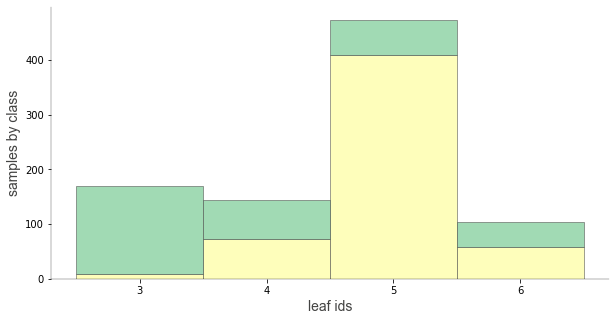

In [29]:
ctreeviz_leaf_samples(xgb_model, x_dataset=dataset[features], y_dataset=dataset[target], shadow_type=2  )